# 导入包

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
import statsmodels.api as sm

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, RocCurveDisplay,ConfusionMatrixDisplay, PrecisionRecallDisplay
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from scipy import stats
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import logit
from statsmodels.tools.tools import add_constant
import warnings
warnings.filterwarnings('ignore')
from pygam import LogisticGAM, s



# 导入数据，对'famhist'项进行编码，检查缺失值

In [2]:
# 定义数据文件的路径
file_path = r"E:\big work of ml\南非心脏病数据.txt"

# 读取数据，假设是以空格或制表符（tab）分隔的
data = pd.read_csv(file_path, delimiter='\s+')
print("前几行数据:")
print(data.head())
print("\n数据总数 (行, 列):")
print(data.shape)
print("\n数据类型:")
print(data.dtypes)
if 'famhist' in data.columns:
    data['famhist'] = data['famhist'].map({'Present': 1, 'Absent': 0})
    print("\n编码后的 'famhist' 列前几行:")
    print(data['famhist'].head())
# 确认编码是否成功
print("\n编码后 'famhist' 的唯一值:")
print(data['famhist'].unique())
print(data.describe())
print("\n缺失值检查:")
print(data.isnull().sum())
print("\n编码后 'famhist' 的唯一值:")
print(data['famhist'].unique())

前几行数据:
   sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age  chd
0  160    12.00  5.73      23.11  Present     49    25.30    97.20   52    1
1  144     0.01  4.41      28.61   Absent     55    28.87     2.06   63    1
2  118     0.08  3.48      32.28  Present     52    29.14     3.81   46    0
3  170     7.50  6.41      38.03  Present     51    31.99    24.26   58    1
4  134    13.60  3.50      27.78  Present     60    25.99    57.34   49    1

数据总数 (行, 列):
(462, 10)

数据类型:
sbp            int64
tobacco      float64
ldl          float64
adiposity    float64
famhist       object
typea          int64
obesity      float64
alcohol      float64
age            int64
chd            int64
dtype: object

编码后的 'famhist' 列前几行:
0    1
1    0
2    1
3    1
4    1
Name: famhist, dtype: int64

编码后 'famhist' 的唯一值:
[1 0]
              sbp     tobacco         ldl   adiposity     famhist       typea  \
count  462.000000  462.000000  462.000000  462.000000  462.000000  462.000000   
me

# 去除极端值和标准化

In [3]:
# 确认 'chd' 列的唯一值（'chd' 是目标变量）
if 'chd' in data.columns:
    print("\n'chd' 的唯一值:")
    print(data['chd'].unique())

# 选择数值类型的列
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 指定需要排除的列
cols_to_exclude = ['famhist', 'chd']

# 将需要排除的列从数值列中移除（如果存在）
numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]

print("\n需要检查和去除极端值的数值列:", numeric_cols)

# 计算 Z-score
z_scores = np.abs(stats.zscore(data[numeric_cols]))

# 设置 Z-score 阈值，通常 |Z| > 3 被认为是极端值
threshold = 3

# 检测极端值的位置
outliers = (z_scores > threshold).any(axis=1)

# 输出有多少极端值
print(f"发现 {outliers.sum()} 个极端值样本。")

# 删除这些极端值
data_cleaned = data[~outliers]

print(f"删除极端值后的数据形状: {data_cleaned.shape}")

# 重新选择数值类型的列（排除 'famhist' 和 'chd'）
numeric_cols_cleaned = [col for col in numeric_cols if col in data_cleaned.columns]

print("\n需要标准化的数值列:", numeric_cols_cleaned)

# 初始化 StandardScaler
scaler = StandardScaler()

# 拟合并转换数值数据
data_scaled = scaler.fit_transform(data_cleaned[numeric_cols_cleaned])

# 将标准化后的数据转换回 DataFrame，并保持原有的列名
data_scaled = pd.DataFrame(data_scaled, columns=numeric_cols_cleaned, index=data_cleaned.index)

# 将标准化后的数值数据与非数值数据（如 'famhist' 和 'chd'）合并
data_final = pd.concat([data_scaled, data_cleaned[cols_to_exclude]], axis=1)

# 查看标准化后的数据前几行
print("\n标准化后的数据前几行:")
print(data_final.head())

# 查看数据的描述性统计，确认标准化效果
print("\n标准化后数据的描述性统计:")
print(data_final.describe())


'chd' 的唯一值:
[1 0]

需要检查和去除极端值的数值列: ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age']
发现 41 个极端值样本。
删除极端值后的数据形状: (421, 10)

需要标准化的数值列: ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age']

标准化后的数据前几行:
        sbp   tobacco       ldl  adiposity     typea   obesity   alcohol  \
1  0.419544 -0.847256 -0.091844   0.465824  0.204035  0.785953 -0.656554   
2 -1.048592 -0.828294 -0.611869   0.940686 -0.112934  0.855226 -0.566158   
3  1.887680  1.181681  1.026489   1.684681 -0.218591  1.586442  0.490184   
4 -0.145124  2.834085 -0.600685   0.358430  0.732316  0.047041  2.198927   
5 -0.258057  0.829529  1.060039   1.449190  0.943629  1.273430 -0.032563   

        age  famhist  chd  
1  1.423183        0    1  
2  0.268077        1    0  
3  1.083446        1    1  
4  0.471920        1    1  
5  0.200130        1    0  

标准化后数据的描述性统计:
                sbp       tobacco           ldl     adiposity         typea  \
count  4.210000e+02  4.210000

# 相关系数矩阵及可视化

                sbp   tobacco       ldl  adiposity     typea   obesity  \
sbp        1.000000  0.176726  0.216120   0.365451 -0.072947  0.296126   
tobacco    0.176726  1.000000  0.196769   0.308452  0.008411  0.164231   
ldl        0.216120  0.196769  1.000000   0.462736  0.033600  0.376111   
adiposity  0.365451  0.308452  0.462736   1.000000 -0.061012  0.765086   
typea     -0.072947  0.008411  0.033600  -0.061012  1.000000  0.052592   
obesity    0.296126  0.164231  0.376111   0.765086  0.052592  1.000000   
alcohol    0.148785  0.238313 -0.050479   0.133864  0.009810  0.121322   
age        0.387176  0.457826  0.366162   0.637513 -0.110953  0.337564   
famhist    0.118159  0.178355  0.199811   0.199832  0.034663  0.135780   

            alcohol       age   famhist  
sbp        0.148785  0.387176  0.118159  
tobacco    0.238313  0.457826  0.178355  
ldl       -0.050479  0.366162  0.199811  
adiposity  0.133864  0.637513  0.199832  
typea      0.009810 -0.110953  0.034663  
obesity

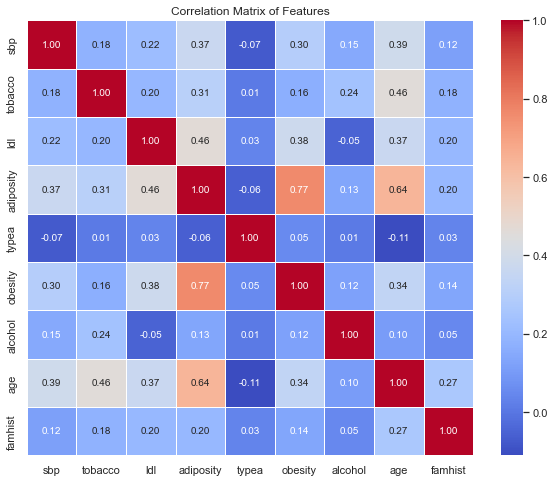

In [4]:
# 设置绘图风格
sns.set(style="whitegrid", palette="muted", color_codes=True)
# 删除目标变量 'chd'，只计算特征的相关系数矩阵
features = data_final.drop(columns=['chd'])

# 计算相关系数矩阵
correlation_matrix = features.corr()  # 计算皮尔逊相关系数矩阵
print(correlation_matrix)
# 可视化相关系数矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()


# 获取描述性统计


In [5]:
desc_stats = features.describe()
print(desc_stats)


                sbp       tobacco           ldl     adiposity         typea  \
count  4.210000e+02  4.210000e+02  4.210000e+02  4.210000e+02  4.210000e+02   
mean  -7.088550e-16 -8.438750e-18  4.388150e-16  2.299559e-16 -2.531625e-16   
std    1.001190e+00  1.001190e+00  1.001190e+00  1.001190e+00  1.001190e+00   
min   -2.008527e+00 -8.499644e-01 -2.009784e+00 -2.363943e+00 -2.965655e+00   
25%   -7.097913e-01 -8.418378e-01 -7.292936e-01 -7.258613e-01 -6.412159e-01   
50%   -1.451236e-01 -3.894582e-01 -1.533524e-01  9.706119e-02 -7.277989e-03   
75%    5.324776e-01  4.096556e-01  5.679722e-01  7.543640e-01  7.323163e-01   
max    3.242882e+00  3.484212e+00  3.358212e+00  2.220356e+00  2.634130e+00   

            obesity       alcohol           age     famhist  
count  4.210000e+02  4.210000e+02  4.210000e+02  421.000000  
mean  -2.447237e-16 -3.375500e-17  3.375500e-17    0.413302  
std    1.001190e+00  1.001190e+00  1.001190e+00    0.493012  
min   -2.849597e+00 -7.629633e-01 -1.838

# 计算VIF(方差膨胀因子)

     Feature       VIF
0        sbp  1.241939
1    tobacco  1.340871
2        ldl  1.339602
3  adiposity  4.128364
4      typea  1.045391
5    obesity  2.748950
6    alcohol  1.106764
7        age  2.265299
8    famhist  1.055453


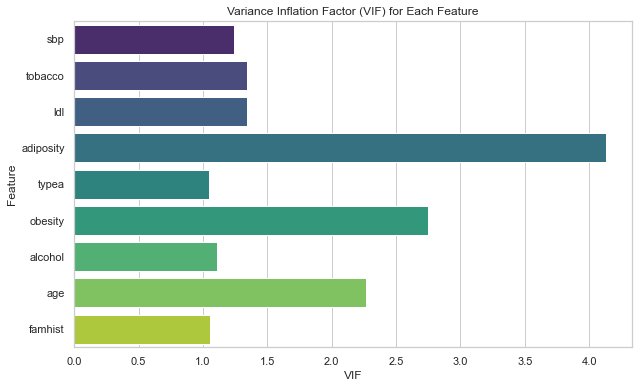

In [6]:
# 计算VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print(vif_data)

# 绘制 VIF 条形图
plt.figure(figsize=(10, 6))
sns.barplot(x="VIF", y="Feature", data=vif_data, palette="viridis")

# 设置图表标题和标签
plt.title('Variance Inflation Factor (VIF) for Each Feature')
plt.xlabel('VIF')
plt.ylabel('Feature')

# 显示图表
plt.show()

# 提取主成分

In [7]:
# 假设 'data_final 是你已经清洗和标准化过的数据集
# 删除目标变量 'chd'，仅保留特征
features = data_final.drop(columns=['chd'])

# 提取需要合并的相关特征（'adiposity' 和 'obesity'）
relevant_features = features[['adiposity', 'obesity']]

# 标准化这些特征（PCA 需要标准化数据）
scaler = StandardScaler()
relevant_features_scaled = scaler.fit_transform(relevant_features)

# 对相关特征应用 PCA，提取主成分
pca = PCA(n_components=1)  # 提取 1 个主成分
principal_components = pca.fit_transform(relevant_features_scaled)

# 将 PCA 提取的主成分作为新的特征列添加到数据集中
features['adiposity_obesity_pc'] = principal_components

# 删除原来的 'adiposity' 和 'obesity' 列
features = features.drop(columns=['adiposity', 'obesity'])
data = features.assign(chd=data_cleaned['chd'])
# 查看合并后的特征数据
print(features.head(),data.head())

        sbp   tobacco       ldl     typea   alcohol       age  famhist  \
1  0.419544 -0.847256 -0.091844  0.204035 -0.656554  1.423183        0   
2 -1.048592 -0.828294 -0.611869 -0.112934 -0.566158  0.268077        1   
3  1.887680  1.181681  1.026489 -0.218591  0.490184  1.083446        1   
4 -0.145124  2.834085 -0.600685  0.732316  2.198927  0.471920        1   
5 -0.258057  0.829529  1.060039  0.943629 -0.032563  0.200130        1   

   adiposity_obesity_pc  
1              0.885140  
2              1.269902  
3              2.313033  
4              0.286711  
5              1.925183           sbp   tobacco       ldl     typea   alcohol       age  famhist  \
1  0.419544 -0.847256 -0.091844  0.204035 -0.656554  1.423183        0   
2 -1.048592 -0.828294 -0.611869 -0.112934 -0.566158  0.268077        1   
3  1.887680  1.181681  1.026489 -0.218591  0.490184  1.083446        1   
4 -0.145124  2.834085 -0.600685  0.732316  2.198927  0.471920        1   
5 -0.258057  0.829529  1.0600

                           sbp   tobacco       ldl     typea   alcohol  \
sbp                   1.000000  0.176726  0.216120 -0.072947  0.148785   
tobacco               0.176726  1.000000  0.196769  0.008411  0.238313   
ldl                   0.216120  0.196769  1.000000  0.033600 -0.050479   
typea                -0.072947  0.008411  0.033600  1.000000  0.009810   
alcohol               0.148785  0.238313 -0.050479  0.009810  1.000000   
age                   0.387176  0.457826  0.366162 -0.110953  0.103655   
famhist               0.118159  0.178355  0.199811  0.034663  0.046773   
adiposity_obesity_pc  0.352113  0.251578  0.446463 -0.004481  0.135819   

                           age   famhist  adiposity_obesity_pc  
sbp                   0.387176  0.118159              0.352113  
tobacco               0.457826  0.178355              0.251578  
ldl                   0.366162  0.199811              0.446463  
typea                -0.110953  0.034663             -0.004481  
alcohol 

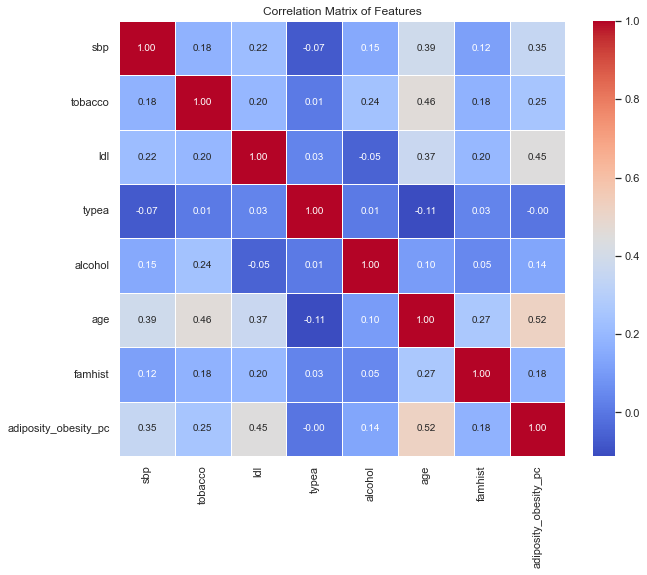

In [8]:
# 计算相关系数矩阵
correlation_matrix = features.corr()  # 计算皮尔逊相关系数矩阵
print(correlation_matrix)
# 可视化相关系数矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

                Feature       VIF
0                   sbp  1.240348
1               tobacco  1.340157
2                   ldl  1.333026
3                 typea  1.029044
4               alcohol  1.106692
5                   age  1.814799
6               famhist  1.055352
7  adiposity_obesity_pc  1.599884


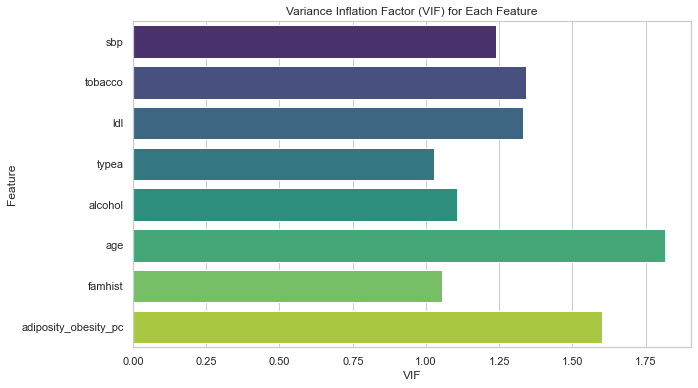

In [9]:
# 重新计算VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print(vif_data)

# 绘制 VIF 条形图
plt.figure(figsize=(10, 6))
sns.barplot(x="VIF", y="Feature", data=vif_data, palette="viridis")

# 设置图表标题和标签
plt.title('Variance Inflation Factor (VIF) for Each Feature')
plt.xlabel('VIF')
plt.ylabel('Feature')

# 显示图表
plt.show()

### 患病比例

        sbp   tobacco       ldl     typea   alcohol       age  famhist  \
1  0.419544 -0.847256 -0.091844  0.204035 -0.656554  1.423183        0   
2 -1.048592 -0.828294 -0.611869 -0.112934 -0.566158  0.268077        1   
3  1.887680  1.181681  1.026489 -0.218591  0.490184  1.083446        1   
4 -0.145124  2.834085 -0.600685  0.732316  2.198927  0.471920        1   
5 -0.258057  0.829529  1.060039  0.943629 -0.032563  0.200130        1   

   adiposity_obesity_pc  chd  
1              0.885140    1  
2              1.269902    0  
3              2.313033    1  
4              0.286711    1  
5              1.925183    0  
患病比例: 32.07%


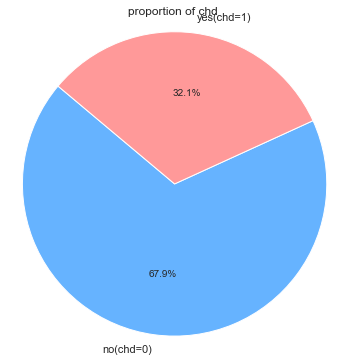

In [10]:
print(data.head())
# 计算患病比例
chd_proportion = data['chd'].mean()

print(f"患病比例: {chd_proportion:.2%}")
chd_counts = data['chd'].value_counts()

# 定义标签
labels = ['no(chd=0)', 'yes(chd=1)']
colors = ['#66b3ff', '#ff9999']

# 绘制饼图
plt.figure(figsize=(6,6))
plt.pie(chd_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('proportion of chd ')
plt.axis('equal')  # 确保饼图为圆形
plt.show()


### 对于每个连续变量，进行 独立样本 t 检验。t 检验的目的是判断两组（有无心脏病）在这些连续变量上的均值是否存在显著差异。

In [11]:
# 定义连续变量列表
continuous_vars = ['sbp', 'tobacco', 'ldl', 'typea', 'alcohol', 'age', 'adiposity_obesity_pc']

# 进行 t 检验
for var in continuous_vars:
    group0 = data[data['chd'] == 0][var]
    group1 = data[data['chd'] == 1][var]
    t_stat, p_val = stats.ttest_ind(group0, group1)
    print(f"{var} 的 t 检验结果: t={t_stat:.4f}, p-value={p_val:.4f}")


sbp 的 t 检验结果: t=-3.0087, p-value=0.0028
tobacco 的 t 检验结果: t=-6.1480, p-value=0.0000
ldl 的 t 检验结果: t=-6.4383, p-value=0.0000
typea 的 t 检验结果: t=-2.5703, p-value=0.0105
alcohol 的 t 检验结果: t=-0.7206, p-value=0.4716
age 的 t 检验结果: t=-7.9122, p-value=0.0000
adiposity_obesity_pc 的 t 检验结果: t=-3.9643, p-value=0.0001


### 进行 卡方检验，用来检验两个分类变量（famhist 和 chd）之间是否独立。famhist 表示是否有家族心脏病历史（0表示无，1表示有），chd 表示是否患有心脏病。

In [12]:
contingency_table = pd.crosstab(data['famhist'], data['chd'])
chi2, p, dof, ex = chi2_contingency(contingency_table)
print(f"famhist 与 chd 的卡方检验结果: chi2={chi2:.4f}, p-value={p:.4f}")


famhist 与 chd 的卡方检验结果: chi2=27.4438, p-value=0.0000


### 使用小提琴图（Violin Plot）

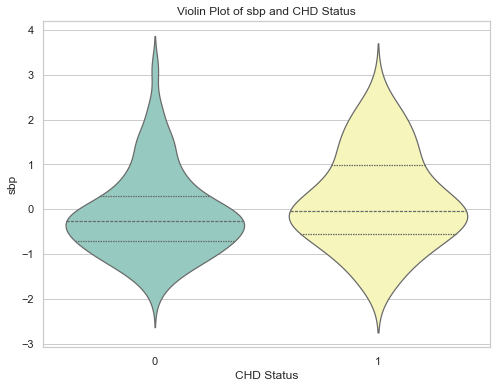

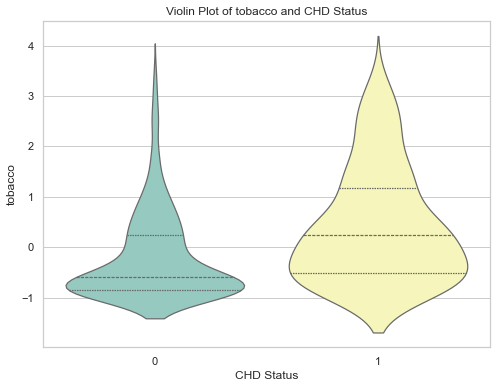

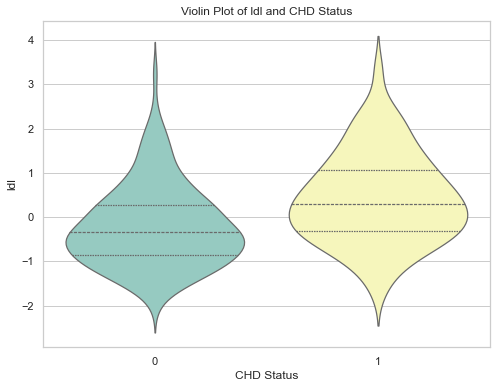

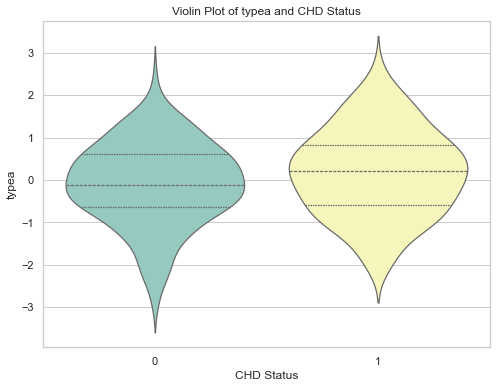

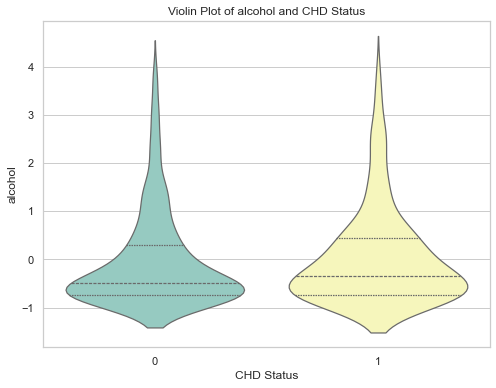

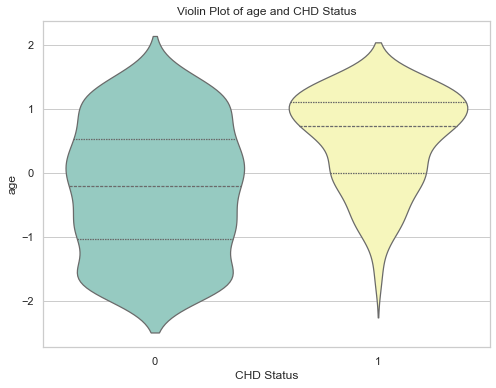

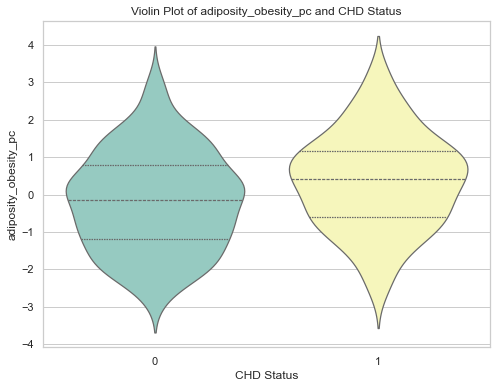

In [13]:
for var in continuous_vars:
    plt.figure(figsize=(8, 6))
    sns.violinplot(x='chd', y=var, data=data, palette='Set3', inner='quartile')
    plt.title(f'Violin Plot of {var} and CHD Status')
    plt.xlabel('CHD Status')
    plt.ylabel(var)
    plt.show()


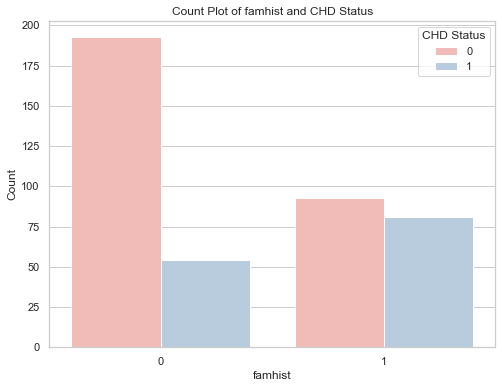

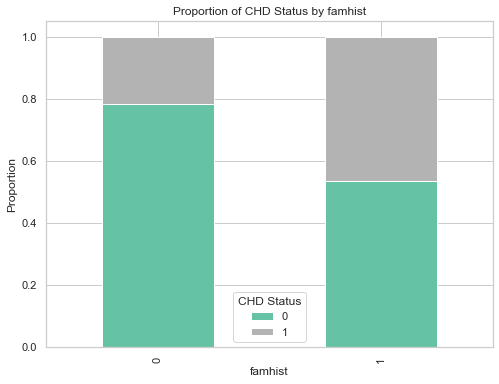

In [14]:
# 分类变量列表
categorical_vars = ['famhist']

for var in categorical_vars:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=var, hue='chd', data=data, palette='Pastel1')
    plt.title(f'Count Plot of {var} and CHD Status')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.legend(title='CHD Status')
    plt.show()
# 计算交叉表
ct = pd.crosstab(data['famhist'], data['chd'], normalize='index')

# 绘制堆积条形图
ct.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='Set2')
plt.title('Proportion of CHD Status by famhist')
plt.xlabel('famhist')
plt.ylabel('Proportion')
plt.legend(title='CHD Status')
plt.show()


### 单独研究酒精选项

alcohol_cat
Low          110
High         106
Very High    104
Medium       101
Name: count, dtype: int64


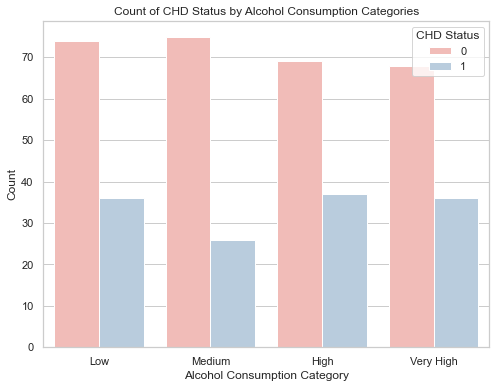

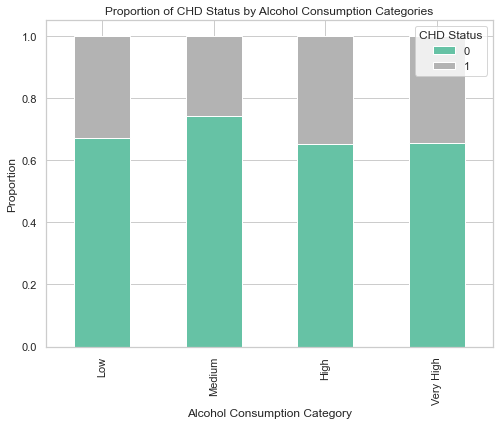

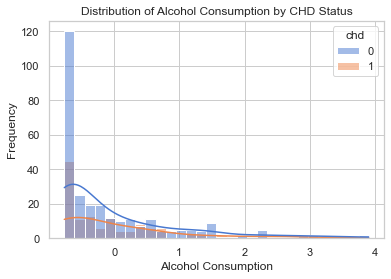

In [15]:
# Create quantile-based bins
data['alcohol_cat'] = pd.qcut(data['alcohol'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Verify the new categorical variable
print(data['alcohol_cat'].value_counts())
plt.figure(figsize=(8, 6))
sns.countplot(x='alcohol_cat', hue='chd', data=data, palette='Pastel1')
plt.title('Count of CHD Status by Alcohol Consumption Categories')
plt.xlabel('Alcohol Consumption Category')
plt.ylabel('Count')
plt.legend(title='CHD Status')
plt.show()
# Calculate proportions
proportions = data.groupby('alcohol_cat')['chd'].value_counts(normalize=True).unstack()

# Plot stacked bar chart
proportions.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='Set2')
plt.title('Proportion of CHD Status by Alcohol Consumption Categories')
plt.xlabel('Alcohol Consumption Category')
plt.ylabel('Proportion')
plt.legend(title='CHD Status')
plt.show()


sns.histplot(data=data, x='alcohol', hue='chd', kde=True, bins=30)
plt.title('Distribution of Alcohol Consumption by CHD Status')
plt.xlabel('Alcohol Consumption')
plt.ylabel('Frequency')
plt.show()

### 划分测试集和训练集

In [16]:
# 定义特征和目标变量
X = data[['sbp', 'tobacco', 'ldl', 'typea', 'age','alcohol','adiposity_obesity_pc', 'famhist']]
y = data['chd']
# 划分数据集（80% 训练，20% 测试）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# 查看划分后的数据集大小
print(f"训练集样本数: {X_train.shape[0]}")
print(f"测试集样本数: {X_test.shape[0]}")

训练集样本数: 336
测试集样本数: 85


### 一般逻辑回归

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Parameters:
{'logreg__C': 10, 'logreg__class_weight': None, 'logreg__penalty': 'l1'}
Best Cross-Validation AUC: 0.7705

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        58
           1       0.62      0.37      0.47        27

    accuracy                           0.73        85
   macro avg       0.69      0.63      0.64        85
weighted avg       0.71      0.73      0.71        85



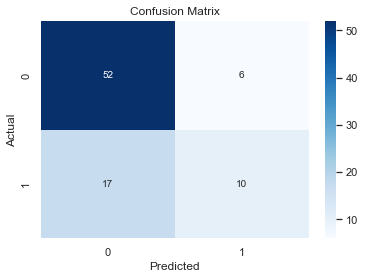

AUC: 0.8084


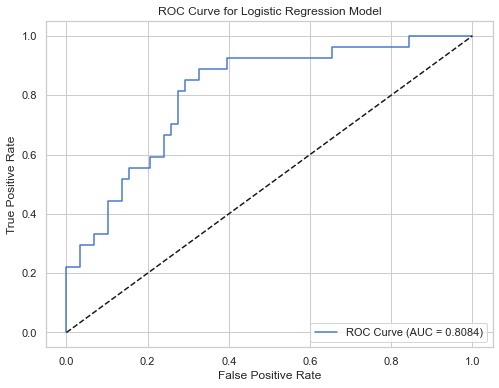

Optimization terminated successfully.
         Current function value: 0.506619
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    chd   No. Observations:                  336
Model:                          Logit   Df Residuals:                      327
Method:                           MLE   Df Model:                            8
Date:                Fri, 20 Dec 2024   Pseudo R-squ.:                  0.1932
Time:                        19:18:30   Log-Likelihood:                -170.22
converged:                       True   LL-Null:                       -210.99
Covariance Type:            nonrobust   LLR p-value:                 2.406e-14
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.2614      0.193     -6.539      0.000      -1.639      -0.883

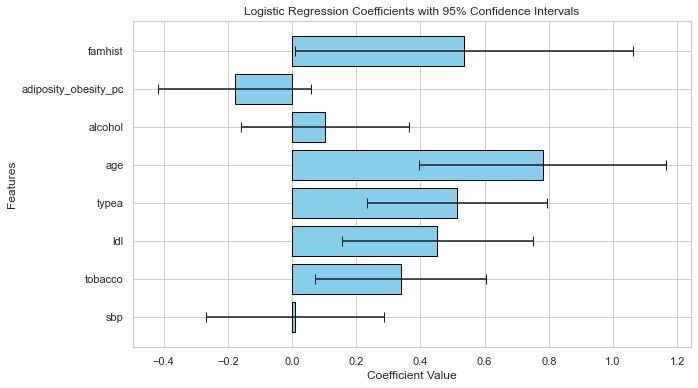

In [17]:
# 构建管道
pipeline = Pipeline([
    ('logreg', LogisticRegression(solver='liblinear', random_state=42))  # 逻辑回归
])

# 定义超参数网格
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],          # 正则化强度
    'logreg__penalty': ['l1', 'l2'],              # 正则化类型
    'logreg__class_weight': [None, 'balanced']    # 类别权重
}

#  超参数优化与交叉验证
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                     # 5 折交叉验证
    scoring='roc_auc',       # 评估指标为 AUC
    n_jobs=-1,                # 使用所有可用的处理器
    verbose=2
)

# 进行超参数搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数和得分
print("\nBest Parameters:")
print(grid_search.best_params_)
print(f"Best Cross-Validation AUC: {grid_search.best_score_:.4f}")

# 评估最佳模型
best_model = grid_search.best_estimator_

# 在测试集上进行预测
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# 分类报告
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')  # 混淆矩阵
plt.xlabel('Predicted')        # 预测值
plt.ylabel('Actual')           # 真实值
plt.show()

# 计算 AUC
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {test_auc:.4f}")

# 绘制 ROC 曲线
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {test_auc:.4f})')  # ROC曲线
plt.plot([0, 1], [0, 1], 'k--')  # 随机分类器的 ROC 曲线
plt.xlabel('False Positive Rate')  # 假阳性率
plt.ylabel('True Positive Rate')   # 真阳性率
plt.title('ROC Curve for Logistic Regression Model')  # ROC曲线
plt.legend(loc='lower right')
plt.show()


# 使用 Statsmodels 进行详细统计分析
# 添加截距项
X_train_sm = sm.add_constant(X_train)

# 拟合逻辑回归模型
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

# 输出摘要报告
print(result.summary())
# 保存和加载模型（可选）
# 保存最佳模型
with open('best_logreg_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("Best Logistic Regression model saved as 'best_logreg_model.pkl'.")

# 加载保存的模型（在需要时）
with open('best_logreg_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# 使用加载的模型进行预测
y_loaded_pred = loaded_model.predict(X_test)
y_loaded_pred_proba = loaded_model.predict_proba(X_test)[:, 1]

# 逻辑回归模型结果
coefficients = result.params[1:]  # 去除截距项
std_err = result.bse[1:]  # 去除截距项的标准误差
conf_int = result.conf_int()[1:]  # 去除截距项的置信区间

# 计算置信区间
lower_bound = conf_int[0]  # 置信区间下界
upper_bound = conf_int[1]  # 置信区间上界

# 特征名（对应模型的特征变量）
features = X_train.columns

# 创建图表
plt.figure(figsize=(10, 6))

# 绘制回归系数条形图
plt.barh(features, coefficients, xerr=[coefficients - lower_bound, upper_bound - coefficients], capsize=5, color='skyblue', edgecolor='black')

# 设置图表标题和标签
plt.title('Logistic Regression Coefficients with 95% Confidence Intervals')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')

# 显示图表
plt.show()

### 逐步删除法，基于pvaluve

Dropped 'sbp' with p-value 0.9213
Dropped 'alcohol' with p-value 0.8493
Dropped 'adiposity_obesity_pc' with p-value 0.1993

最终模型摘要:
                           Logit Regression Results                           
Dep. Variable:                    chd   No. Observations:                  421
Model:                          Logit   Df Residuals:                      415
Method:                           MLE   Df Model:                            5
Date:                Fri, 20 Dec 2024   Pseudo R-squ.:                  0.1992
Time:                        19:18:30   Log-Likelihood:                -211.52
converged:                       True   LL-Null:                       -264.12
Covariance Type:            nonrobust   LLR p-value:                 4.224e-21
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3244      0.174     -7.592      0.000      -1.666      -0.982

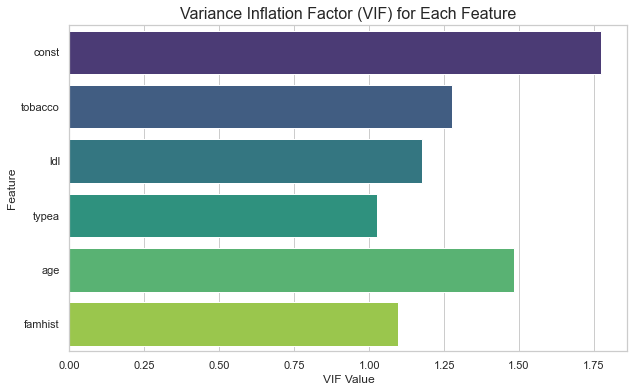

<function matplotlib.pyplot.show(close=None, block=None)>

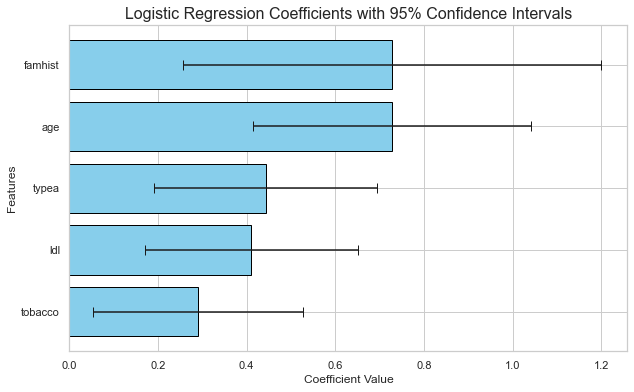

In [18]:
def backward_elimination(X, y, significance_level=0.05):
    while True:
        model = sm.Logit(y, X).fit(disp=0)
        p_values = model.pvalues.iloc[1:]  # 排除截距项
        max_p = p_values.max()
        if max_p > significance_level:
            excluded_feature = p_values.idxmax()
            print(f"Dropped '{excluded_feature}' with p-value {max_p:.4f}")
            X = X.drop(columns=[excluded_feature])
        else:
            break
    return model, X

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# 假设 data 是已经预处理好的数据集
# 分割特征和目标变量
X = data[['sbp', 'tobacco', 'ldl', 'typea', 'age', 'alcohol', 'adiposity_obesity_pc', 'famhist']]

y = data['chd']

# 添加截距项
X = sm.add_constant(X)

# 自动逐步剔除不显著变量
final_model, final_X = backward_elimination(X, y, significance_level=0.05)

# 输出最终模型的摘要报告
print("\n最终模型摘要:")
print(final_model.summary())

# 计算并打印 VIF
vif = calculate_vif(final_X)
print("\n各特征的方差膨胀因子（VIF）:")
print(vif)
# 绘制VIF图
plt.figure(figsize=(10, 6))
sns.barplot(x='VIF', y='Feature', data=vif, palette='viridis')

# 添加图标题和轴标签
plt.title('Variance Inflation Factor (VIF) for Each Feature', fontsize=16)
plt.xlabel('VIF Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# 显示图形
plt.show()
# 获取最终模型的系数和置信区间
coefficients = final_model.params[1:]  # 去除截距项
conf_int = final_model.conf_int()  # 获取置信区间
lower_bound = conf_int[0][1:]  # 置信区间下界
upper_bound = conf_int[1][1:]  # 置信区间上界

# 特征名（对应模型的特征变量）
features = final_X.columns[1:]  # 去除截距项

# 创建图表
plt.figure(figsize=(10, 6))

# 绘制回归系数条形图
plt.barh(features, coefficients, xerr=[coefficients - lower_bound, upper_bound - coefficients], capsize=5, color='skyblue', edgecolor='black')

# 设置图表标题和标签
plt.title('Logistic Regression Coefficients with 95% Confidence Intervals', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Features', fontsize=12)

# 显示图表
plt.show

### 基于删除后的模型预测

删除变量后的训练集特征形状: (336, 5)
删除变量后的测试集特征形状: (85, 5)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
最佳参数组合:
{'logreg__C': 0.01, 'logreg__penalty': 'l2'}
最佳交叉验证ROC-AUC得分: 0.7702

分类报告:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83        58
           1       0.65      0.48      0.55        27

    accuracy                           0.75        85
   macro avg       0.72      0.68      0.69        85
weighted avg       0.74      0.75      0.74        85

混淆矩阵:
[[51  7]
 [14 13]]


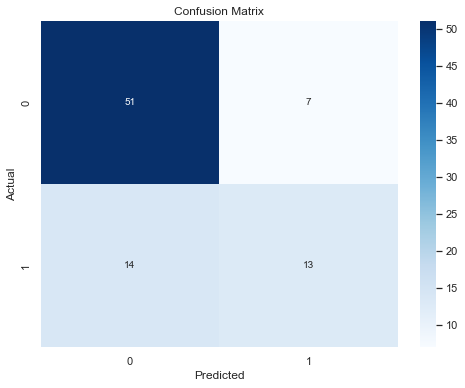

ROC-AUC: 0.8231


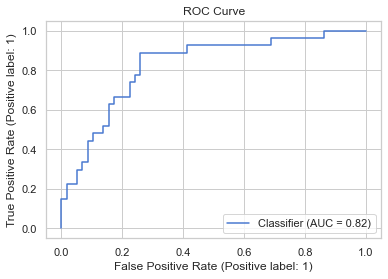

Optimization terminated successfully.
         Current function value: 0.510470
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    chd   No. Observations:                  336
Model:                          Logit   Df Residuals:                      330
Method:                           MLE   Df Model:                            5
Date:                Fri, 20 Dec 2024   Pseudo R-squ.:                  0.1871
Time:                        19:18:32   Log-Likelihood:                -171.52
converged:                       True   LL-Null:                       -210.99
Covariance Type:            nonrobust   LLR p-value:                 1.397e-15
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2450      0.191     -6.514      0.000      -1.620      -0.870
tobacco        0.3478      0.

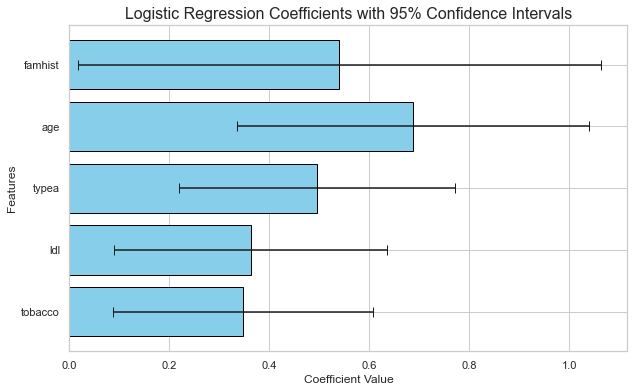

In [19]:

# 删除不显著的变量
X_train_selected = X_train.drop(columns=['sbp', 'alcohol', 'adiposity_obesity_pc'])
X_test_selected = X_test.drop(columns=['sbp', 'alcohol', 'adiposity_obesity_pc'])

# 查看删除后的形状
print(f"删除变量后的训练集特征形状: {X_train_selected.shape}")
print(f"删除变量后的测试集特征形状: {X_test_selected.shape}")

# 创建一个包含标准化和逻辑回归的管道
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='liblinear', random_state=42))
])
# 定义超参数网格
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],  # 正则化强度
    'logreg__penalty': ['l1', 'l2']        # 正则化类型
}
# 定义交叉验证策略
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# 定义GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',  # 使用ROC-AUC作为评估指标
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# 执行超参数搜索
grid_search.fit(X_train_selected, y_train)
# 打印最佳参数
print("最佳参数组合:")
print(grid_search.best_params_)

# 打印最佳ROC-AUC得分
print(f"最佳交叉验证ROC-AUC得分: {grid_search.best_score_:.4f}")
# 使用最佳模型进行预测
best_model = grid_search.best_estimator_

# 预测概率
y_pred_proba = best_model.predict_proba(X_test_selected)[:,1]

# 预测类别（阈值设为0.5）
y_pred = (y_pred_proba >= 0.5).astype(int)
from sklearn.metrics import classification_report

print("\n分类报告:")
print(classification_report(y_test, y_pred))
from sklearn.metrics import confusion_matrix

print("混淆矩阵:")
print(confusion_matrix(y_test, y_pred))

# 可视化混淆矩阵
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['0', '1'],
                     columns=['0', '1'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# 计算ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

# 绘制ROC曲线
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title('ROC Curve')
plt.show()
from sklearn.metrics import precision_recall_curve, auc

# 提取最佳模型的参数
# 首先，获取训练数据中的最佳特征
final_features = X_train_selected.columns
X_train_final = X_train_selected
X_test_final = X_test_selected

# 添加常数项
X_train_final_sm = sm.add_constant(X_train_final)
X_test_final_sm = sm.add_constant(X_test_final)

# 使用statsmodels拟合逻辑回归模型
model_sm = sm.Logit(y_train, X_train_final_sm).fit()

# 输出模型摘要
print(model_sm.summary())
# 使用statsmodels拟合逻辑回归模型
model_sm = sm.Logit(y_train, X_train_final_sm).fit()

# 输出模型摘要
print(model_sm.summary())

# 获取回归系数
coefficients = model_sm.params[1:]  # 去除截距项
# 获取置信区间
conf_int = model_sm.conf_int()  # 返回的是 (lower_bound, upper_bound) 形式
lower_bound = conf_int[0][1:]  # 置信区间下界
upper_bound = conf_int[1][1:]  # 置信区间上界

# 特征名（去除截距项）
features = X_train_final.columns

# 创建图表
plt.figure(figsize=(10, 6))

# 绘制回归系数条形图
plt.barh(features, coefficients, xerr=[coefficients - lower_bound, upper_bound - coefficients], capsize=5, color='skyblue', edgecolor='black')

# 设置图表标题和标签
plt.title('Logistic Regression Coefficients with 95% Confidence Intervals', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Features', fontsize=12)

# 显示图表
plt.show()

### SVM直接运用模型


Fitting 5 folds for each of 72 candidates, totalling 360 fits

分类报告:
              precision    recall  f1-score   support

           0       0.75      0.93      0.83        58
           1       0.69      0.33      0.45        27

    accuracy                           0.74        85
   macro avg       0.72      0.63      0.64        85
weighted avg       0.73      0.74      0.71        85

混淆矩阵:


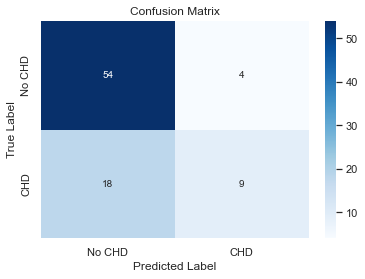

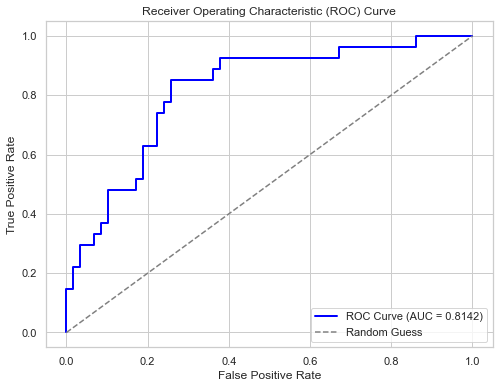

In [20]:

X = data[['sbp', 'tobacco', 'ldl', 'typea', 'age', 'alcohol', 'adiposity_obesity_pc', 'famhist']]
y = data['chd']

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 创建管道，包括标准化和SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(probability=True))  # 启用概率估计以计算ROC-AUC
])

# 定义超参数网格
param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'svc__gamma': ['scale', 'auto'],
    'svc__degree': [3, 4, 5]  # 仅适用于 'poly' 核
}

# 初始化GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

# 拟合GridSearchCV
grid_search.fit(X_train, y_train)

# 最佳模型
best_model = grid_search.best_estimator_

# 在测试集上进行预测
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# 打印分类报告
print("\n分类报告:")
print(classification_report(y_test, y_pred))

# 打印混淆矩阵
cm = confusion_matrix(y_test, y_pred)
print("混淆矩阵:")
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No CHD', 'CHD'], yticklabels=['No CHD', 'CHD'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 计算并绘制ROC曲线
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### 递归特征消除（RFE）与支持向量机（SVM）结合

训练样本数: 336
测试样本数: 85
Fitting 3 folds for each of 10 candidates, totalling 30 fits
最佳超参数:
{'svc__kernel': 'linear', 'svc__gamma': 'auto', 'svc__class_weight': 'balanced', 'svc__C': 0.1, 'rfe__n_features_to_select': 7}

分类报告:
              precision    recall  f1-score   support

           0       0.88      0.74      0.80        58
           1       0.58      0.78      0.67        27

    accuracy                           0.75        85
   macro avg       0.73      0.76      0.74        85
weighted avg       0.78      0.75      0.76        85

混淆矩阵:
[[43 15]
 [ 6 21]]
测试集准确率: 0.7529
测试集ROC-AUC: 0.8244


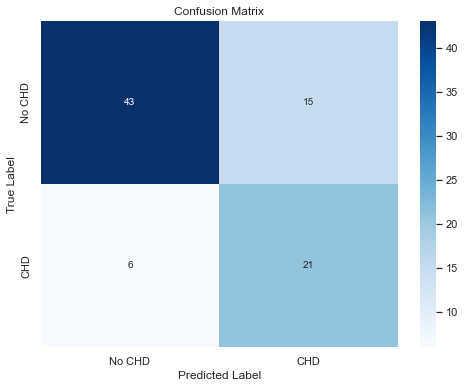

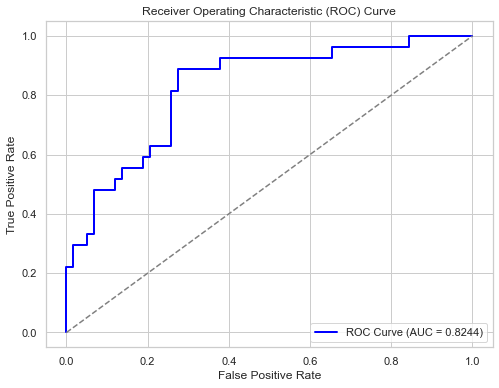

In [21]:

X = data[['sbp', 'tobacco', 'ldl', 'typea', 'age', 'alcohol', 'adiposity_obesity_pc', 'famhist']]
y = data['chd']

# 划分数据集（80% 训练，20% 测试）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"训练样本数: {X_train.shape[0]}")
print(f"测试样本数: {X_test.shape[0]}")

# 创建包含标准化、RFE 和 SVM 的管道
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rfe', RFE(estimator=SVC(kernel='linear'))),  # 使用线性SVM作为特征选择器
    ('svc', SVC(probability=True))  # 启用概率估计以计算ROC-AUC
])

# 定义要搜索的超参数网格
param_dist = {
    'rfe__n_features_to_select': [5, 6, 7],  # 尝试选择不同数量的特征
    'svc__C': [0.1, 1, 10],  # 减少C值的范围
    'svc__kernel': ['linear', 'rbf'],  # 只尝试线性核和RBF核
    'svc__gamma': ['scale', 'auto'],  # gamma的可选值
    'svc__class_weight': ['balanced', None]
}

# 初始化RandomizedSearchCV，减少交叉验证折数
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=10,  # 限制随机搜索的次数
    cv=3,  # 减少交叉验证的折数
    scoring='roc_auc',  # 使用ROC-AUC作为评分标准
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# 在训练数据上拟合RandomizedSearchCV
random_search.fit(X_train, y_train)

# 显示最佳超参数
print("最佳超参数:")
print(random_search.best_params_)

# 使用最佳估计器对测试集进行预测
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # 获取预测的概率值

# 评估模型
print("\n分类报告:")
print(classification_report(y_test, y_pred))

print("混淆矩阵:")
print(confusion_matrix(y_test, y_pred))

print(f"测试集准确率: {accuracy_score(y_test, y_pred):.4f}")
print(f"测试集ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No CHD', 'CHD'], yticklabels=['No CHD', 'CHD'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 计算FPR、TPR和阈值
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 随机猜测的基准线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### 随机森林

训练样本数: 336
测试样本数: 85
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
最佳超参数:
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}

分类报告:
              precision    recall  f1-score   support

           0       0.71      0.84      0.77        58
           1       0.44      0.26      0.33        27

    accuracy                           0.66        85
   macro avg       0.57      0.55      0.55        85
weighted avg       0.62      0.66      0.63        85



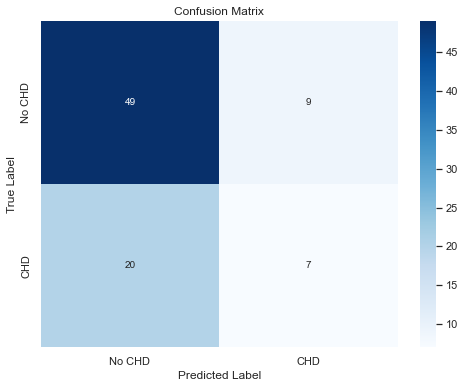

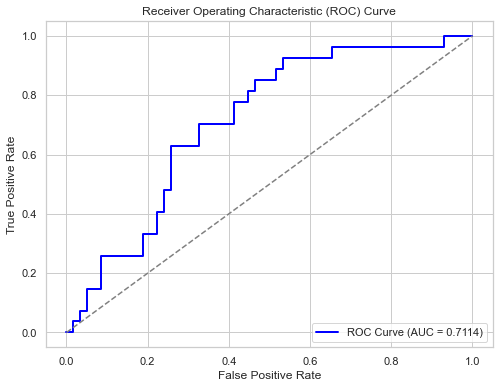

测试集ROC-AUC: 0.7114


In [22]:

X = data[['sbp', 'tobacco', 'ldl', 'typea', 'age', 'alcohol', 'adiposity_obesity_pc', 'famhist']]
y = data['chd']

# 划分数据集（80% 训练，20% 测试）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"训练样本数: {X_train.shape[0]}")
print(f"测试样本数: {X_test.shape[0]}")

# 创建随机森林模型
rf = RandomForestClassifier(random_state=42)

# 定义超参数网格
param_grid = {
    'n_estimators': [50, 100, 200],  # 树的数量
    'max_depth': [None, 10, 20, 30],  # 最大深度
    'min_samples_split': [2, 5, 10],  # 划分节点时最小样本数
    'min_samples_leaf': [1, 2, 4],    # 叶子节点最小样本数
    'bootstrap': [True, False]        # 是否使用bootstrap抽样
}

# 使用GridSearchCV进行超参数优化
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  # 5折交叉验证
    scoring='roc_auc',  # 使用ROC-AUC作为评估指标
    n_jobs=-1,
    verbose=2
)

# 在训练数据上拟合GridSearchCV
grid_search.fit(X_train, y_train)

# 输出最佳超参数
print("最佳超参数:")
print(grid_search.best_params_)

# 使用最佳估计器对测试集进行预测
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # 获取预测的概率值

# 评估模型性能
print("\n分类报告:")
print(classification_report(y_test, y_pred))

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No CHD', 'CHD'], yticklabels=['No CHD', 'CHD'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 随机猜测的基准线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 计算并输出测试集的AUC
print(f"测试集ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")


### xgboost

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
最佳超参数:  {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.6}

分类报告:
              precision    recall  f1-score   support

           0       0.71      0.95      0.81        58
           1       0.62      0.19      0.29        27

    accuracy                           0.71        85
   macro avg       0.67      0.57      0.55        85
weighted avg       0.69      0.71      0.65        85

混淆矩阵:
[[55  3]
 [22  5]]
测试集准确率: 0.7656
测试集ROC-AUC: 0.7656


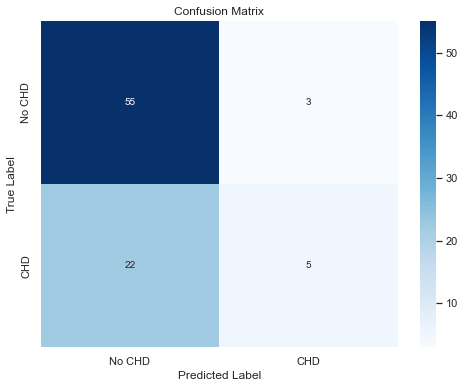

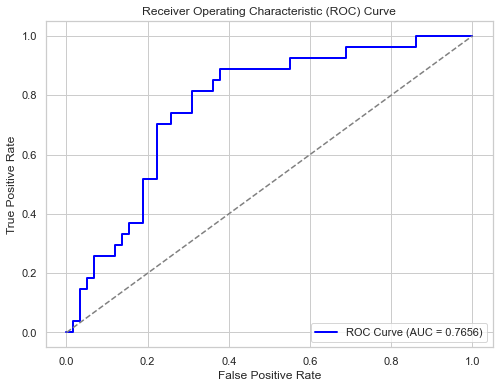

In [23]:

X = data[['sbp', 'tobacco', 'ldl', 'typea', 'age', 'alcohol', 'adiposity_obesity_pc', 'famhist']]
y = data['chd']

# 划分数据集（80% 训练，20% 测试）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  
    random_state=42, 
    stratify=y
)

# 初始化XGBoost分类器
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# 定义超参数搜索空间
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 2, 3]
}

# 使用RandomizedSearchCV进行超参数优化
random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_dist, 
    n_iter=500,  # 限制搜索次数，避免运行时间过长
    scoring='roc_auc',  # 使用ROC-AUC作为评估标准
    cv=3,  # 使用3折交叉验证
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 在训练集上拟合RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳超参数
print("最佳超参数: ", random_search.best_params_)

# 使用最佳估计器进行预测
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # 获取预测的概率值

# 评估模型
print("\n分类报告:")
print(classification_report(y_test, y_pred))

print("混淆矩阵:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print(f"测试集准确率: {random_search.score(X_test, y_test):.4f}")
print(f"测试集ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No CHD', 'CHD'], yticklabels=['No CHD', 'CHD'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 计算FPR、TPR和阈值
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 随机猜测的基准线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### RFE和xgboost结合

Selected features: Index(['tobacco', 'ldl', 'typea', 'age', 'famhist'], dtype='object')
Fitting 3 folds for each of 500 candidates, totalling 1500 fits
最佳超参数:  {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.8}

分类报告:
              precision    recall  f1-score   support

           0       0.72      0.91      0.80        58
           1       0.55      0.22      0.32        27

    accuracy                           0.69        85
   macro avg       0.63      0.57      0.56        85
weighted avg       0.66      0.69      0.65        85

混淆矩阵:
[[53  5]
 [21  6]]
测试集准确率: 0.7893
测试集ROC-AUC: 0.7893


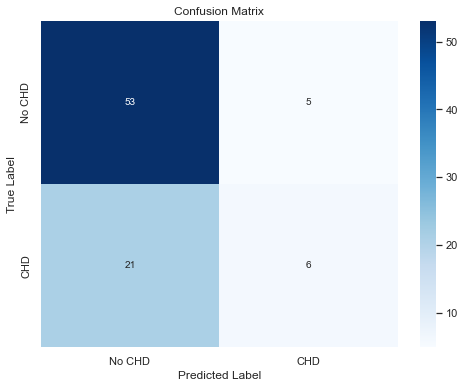

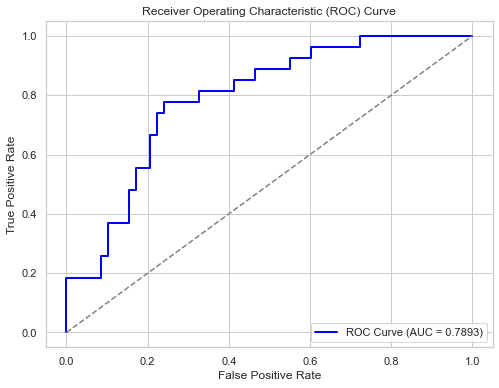

In [24]:

X = data[['sbp', 'tobacco', 'ldl', 'typea', 'age', 'alcohol', 'adiposity_obesity_pc', 'famhist']]
y = data['chd']

# 划分数据集（80% 训练，20% 测试）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  
    random_state=42, 
    stratify=y
)

# 使用支持向量机（SVC）作为基础模型进行RFE特征选择
svc = SVC(kernel="linear", random_state=42)

# 初始化RFE进行特征选择，选择5个特征
rfe = RFE(estimator=svc, n_features_to_select=5)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# 打印被选中的特征
print("Selected features:", X.columns[rfe.support_])

# 初始化XGBoost分类器
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# 定义超参数搜索空间
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 2, 3]
}

# 使用RandomizedSearchCV进行超参数优化
random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_dist, 
    n_iter=500,  # 限制搜索次数，避免运行时间过长
    scoring='roc_auc',  # 使用ROC-AUC作为评估标准
    cv=3,  # 使用3折交叉验证
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 在训练集上拟合RandomizedSearchCV
random_search.fit(X_train_rfe, y_train)

# 输出最佳超参数
print("最佳超参数: ", random_search.best_params_)

# 使用最佳估计器进行预测
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_rfe)
y_proba = best_model.predict_proba(X_test_rfe)[:, 1]  # 获取预测的概率值

# 评估模型
print("\n分类报告:")
print(classification_report(y_test, y_pred))

print("混淆矩阵:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print(f"测试集准确率: {random_search.score(X_test_rfe, y_test):.4f}")
print(f"测试集ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No CHD', 'CHD'], yticklabels=['No CHD', 'CHD'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 计算FPR、TPR和阈值
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 随机猜测的基准线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### KNN

训练样本数: 336
测试样本数: 85
Fitting 5 folds for each of 180 candidates, totalling 900 fits
最佳参数: {'metric': 'euclidean', 'n_neighbors': 26, 'weights': 'distance'}
最佳交叉验证准确率: 0.7082

分类报告:
              precision    recall  f1-score   support

           0       0.69      0.95      0.80        58
           1       0.40      0.07      0.12        27

    accuracy                           0.67        85
   macro avg       0.54      0.51      0.46        85
weighted avg       0.60      0.67      0.58        85



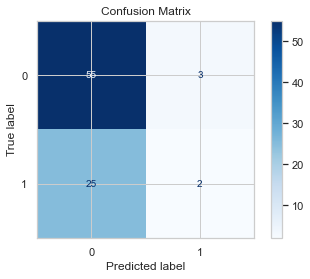

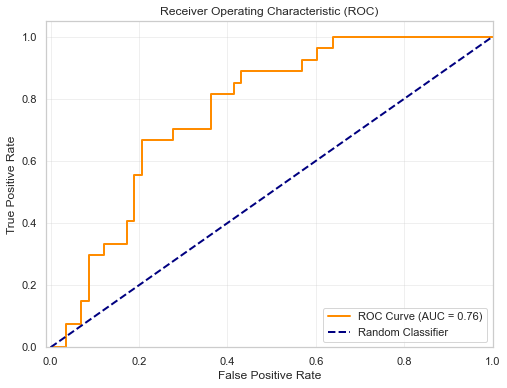

In [25]:

X = data[['sbp', 'tobacco', 'ldl', 'typea', 'age', 'alcohol', 'adiposity_obesity_pc', 'famhist']]
y = data['chd']

# 划分数据集（80% 训练，20% 测试）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  
    random_state=42, 
    stratify=y
)

# 输出训练集和测试集的大小
print(f"训练样本数: {X_train.shape[0]}")
print(f"测试样本数: {X_test.shape[0]}")

# 定义KNN模型
knn = KNeighborsClassifier()

# 定义超参数网格
param_grid = {
    'n_neighbors': list(range(1, 31)),  # 邻居数从1到30
    'weights': ['uniform', 'distance'],  # 权重函数
    'metric': ['euclidean', 'manhattan', 'minkowski']  # 距离度量
}

# 使用网格搜索和5折交叉验证进行超参数优化
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # 使用所有可用的处理器
    verbose=1
)

# 进行网格搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数和最佳得分
print(f"最佳参数: {grid_search.best_params_}")
print(f"最佳交叉验证准确率: {grid_search.best_score_:.4f}")

# 使用最佳参数训练KNN模型
best_knn = grid_search.best_estimator_
best_knn.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = best_knn.predict(X_test)
y_pred_proba = best_knn.predict_proba(X_test)[:,1]  # 获取正类的概率

# 评估模型性能
print("\n分类报告:")
print(classification_report(y_test, y_pred))

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_knn.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")  # 修改为英文
plt.show()

# ROC曲线和AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')  # 修改为英文
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')  # 添加标签
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')  # 修改为英文
plt.ylabel('True Positive Rate')   # 修改为英文
plt.title('Receiver Operating Characteristic (ROC)')  # 修改为英文
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()



### adaboost

Number of training samples: 336
Number of testing samples: 85
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'base_estimator__max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 150}
Best Cross-Validation Accuracy: 0.7172

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.83      0.75        58
           1       0.33      0.19      0.24        27

    accuracy                           0.62        85
   macro avg       0.51      0.51      0.49        85
weighted avg       0.57      0.62      0.59        85



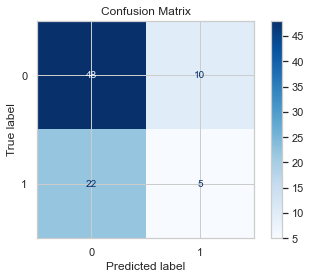

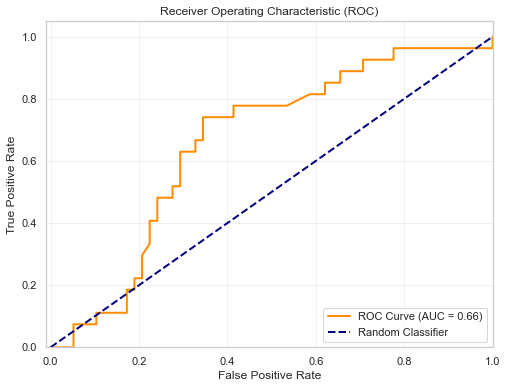

In [26]:

X = data[['sbp', 'tobacco', 'ldl', 'typea', 'age', 'alcohol', 'adiposity_obesity_pc', 'famhist']]
y = data['chd']

# 划分训练集和测试集（80% 训练，20% 测试）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  
    random_state=42, 
    stratify=y
)

# 输出训练集和测试集的大小
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of testing samples: {X_test.shape[0]}")

# 定义 AdaBoost 模型
# 使用 max_depth=1 的决策树作为基分类器
base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)
ada = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)

# 定义超参数网格
param_grid = {
    'n_estimators': [50, 100, 150, 200],             # 提升阶段的数量
    'learning_rate': [0.01, 0.1, 0.5, 1.0],         # 每个分类器的权重
    'base_estimator__max_depth': [1, 2, 3, 4]        # 基分类器的树深度
}

# 使用网格搜索和 5 折交叉验证进行超参数优化
grid_search = GridSearchCV(
    estimator=ada,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # 使用所有可用的处理器
    verbose=1
)

# 执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数和最佳交叉验证准确率
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# 使用最佳参数训练 AdaBoost 模型
best_ada = grid_search.best_estimator_
best_ada.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = best_ada.predict(X_test)
y_pred_proba = best_ada.predict_proba(X_test)[:,1]  # 获取正类的概率

# 评估模型性能
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_ada.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")  # 绘图标题为英文
plt.show()

# ROC 曲线和 AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')  # X轴标签为英文
plt.ylabel('True Positive Rate')    # Y轴标签为英文
plt.title('Receiver Operating Characteristic (ROC)')  # 绘图标题为英文
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


### Gradient Boosting

Number of training samples: 336
Number of testing samples: 85
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.7142

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.88      0.78        58
           1       0.46      0.22      0.30        27

    accuracy                           0.67        85
   macro avg       0.58      0.55      0.54        85
weighted avg       0.63      0.67      0.63        85



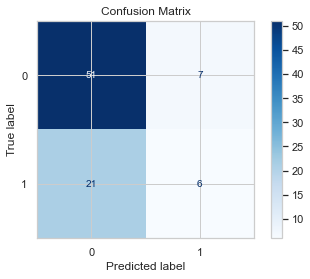

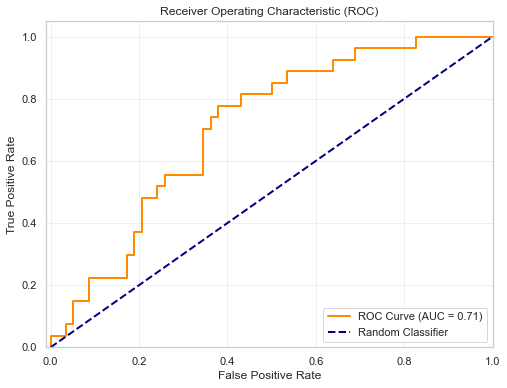

In [27]:

X = data[['sbp', 'tobacco', 'ldl', 'typea', 'age', 'alcohol', 'adiposity_obesity_pc', 'famhist']]
y = data['chd']

# 划分训练集和测试集（80% 训练，20% 测试）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  
    random_state=42, 
    stratify=y
)

# 输出训练集和测试集的大小
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of testing samples: {X_test.shape[0]}")

# 定义梯度提升模型
gbc = GradientBoostingClassifier(random_state=42)

# 定义超参数网格
param_grid = {
    'n_estimators': [100, 200, 300],            # 树的数量
    'learning_rate': [0.01, 0.1, 0.2],         # 学习率
    'max_depth': [3, 4, 5],                     # 每棵树的最大深度
    'subsample': [0.8, 1.0]                     # 采样比例
}

# 使用网格搜索和 5 折交叉验证进行超参数优化
grid_search = GridSearchCV(
    estimator=gbc,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # 使用所有可用的处理器
    verbose=1
)

# 执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数和最佳交叉验证准确率
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# 使用最佳参数训练梯度提升模型
best_gbc = grid_search.best_estimator_
best_gbc.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = best_gbc.predict(X_test)
y_pred_proba = best_gbc.predict_proba(X_test)[:,1]  # 获取正类的概率

# 评估模型性能
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_gbc.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")  # 绘图标题为英文
plt.show()

# ROC 曲线和 AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')  # X轴标签为英文
plt.ylabel('True Positive Rate')    # Y轴标签为英文
plt.title('Receiver Operating Characteristic (ROC)')  # 绘图标题为英文
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
